Energy Disaggregation using Neural Networks
=======================================

In [1]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random

Using TensorFlow backend.


The following functions are used to extract the time and day information from a timestamp value.

In [2]:
def get_month(timevals):
    return dt.fromtimestamp(timevals).month
def get_week(timevals):
    return math.ceil(dt.fromtimestamp(timevals).day/7)
def get_hour(timevals):
    return dt.fromtimestamp(timevals).hour
def get_minute(timevals):
    return dt.fromtimestamp(timevals).minute
def get_second(timevals):
    return dt.fromtimestamp(timevals).second

The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [3]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [4]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


Model Specification
-------------------------------
The following function is used to create the model.

In [73]:
def init_model():
    model = Sequential()
    model.add(Conv1D(16, 4, activation="relu",
                    input_shape=(1200,7), padding="same", strides=1))
    model.add(Dropout(0.25))
    model.add(Bidirectional(LSTM(256, return_sequences=True,
                                  stateful=False), merge_mode='concat'))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='linear'))
    model.add(Dropout(0.25))
    model.compile(loss='mse', optimizer='adam')
    return model

The following function plots the losses against the epochs.

In [6]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

Data Preprocessing
------------------------------

The following function takes as input the file path, the channel index and the quantity name as input and loads the appropriate data files. It then joins themains and the output quantity based on the timestamp values, extracts time features from the timestamp and splits the input and output into two arrays.

In [7]:
def loadData(path, index, name):
    main11 = np.genfromtxt(path+'channel_1.dat', dtype = [int, float],)
    main12 = np.genfromtxt(path1+'channel_2.dat', dtype = [int, float])
    wash1 = np.genfromtxt(path1+'channel_'+index+'.dat', dtype = [int, float])
    maindf1 = pd.DataFrame(main11)
    maindf1.columns = ["timestamp", "mains1"]
    maindf2 = pd.DataFrame(main12)
    maindf2.columns = ["timestamp", "mains2"]
    washdf1 = pd.DataFrame(wash1)
    washdf1.columns = ["timestamp", name]
    traindf1 = maindf1.merge(maindf2, on = ('timestamp'))
    traindf1 = traindf1.merge(washdf1, how="inner", on = ('timestamp'))
    timevals = traindf1["timestamp"]
    traindf1["month"] = timevals.apply(get_month)
    traindf1["week"] = timevals.apply(get_week)
    traindf1["hour"] = timevals.apply(get_hour)
    traindf1["minute"] = timevals.apply(get_minute)
    traindf1["second"] = timevals.apply(get_second)
    y = traindf1[name].values
    
    X = np.column_stack((traindf1["month"].values,traindf1["week"].values,
                     traindf1["hour"].values,traindf1["minute"].values,
                     traindf1["second"].values,traindf1["mains1"].values,
                     traindf1["mains2"].values))
   
    return X,y

In [46]:
def create_seq(X):
    res = []
    for i in range(0,X.shape[0],1200):
        res.append(X[i:i+1200,:])
    res = np.array(res)
    return res
   

In [9]:
path1 = ("low_freq/house_1/")
X, y = loadData(path1, "6", "dishwasher")
y = y.reshape(len(y), 1)

In [47]:
res = create_seq(X[0:3600,:])

In [48]:
res.shape

(3, 1200, 7)

Training and Testing
-------------------------------

The model is trained on the"dishwasher" appliance for house 1. The training set comprises 20000 samples and the testing set comprises 2000 samples. The loss curve is plotted. he predicted values are also plotted against the actual values forthe test set.

W0813 23:13:26.293228  6472 deprecation.py:323] From C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0813 23:13:30.057737  6472 deprecation_wrapper.py:119] From C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 20 samples, validate on 3 samples
Epoch 1/20
 - 129s - loss: 0.0906 - val_loss: 0.3641
Epoch 2/20
 - 31s - loss: 0.6033 - val_loss: 0.0542
Epoch 3/20
 - 26s - loss: 0.0826 - val_loss: 0.0738
Epoch 4/20
 - 21s - loss: 0.1052 - val_loss: 0.0655
Epoch 5/20
 - 21s - loss: 0.0991 - val_loss: 0.0532
Epoch 6/20
 - 22s - loss: 0.0861 - val_loss: 0.0592
Epoch 7/20
 - 21s - loss: 0.0936 - val_loss: 0.0587
Epoch 8/20
 - 23s - loss: 0.0895 - val_loss: 0.0535
Epoch 9/20
 - 22s - loss: 0.0794 - val_loss: 0.0534
Epoch 10/20
 - 23s - loss: 0.0780 - val_loss: 0.0568
Epoch 11/20
 - 23s - loss: 0.0817 - val_loss: 0.0577
Epoch 12/20
 - 23s - loss: 0.0827 - val_loss: 0.0552
Epoch 13/20
 - 23s - loss: 0.0774 - val_loss: 0.0521
Epoch 14/20
 - 23s - loss: 0.0737 - val_loss: 0.0505
Epoch 15/20
 - 24s - loss: 0.0723 - val_loss: 0.0507
Epoch 16/20
 - 24s - loss: 0.0728 - val_loss: 0.0511
Epoch 17/20
 - 24s - loss: 0.0719 - val_loss: 0.0507
Epoch 18/20
 - 24s - loss: 0.0718 - val_loss: 0.0503
Epoch 19/20

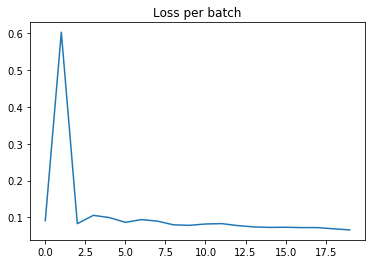

ValueError: x and y can be no greater than 2-D, but have shapes (3,) and (3, 1200, 1)

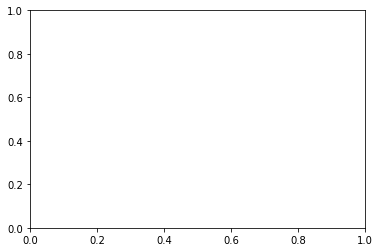

In [69]:

path1 = ("low_freq/house_1/")
X, y = loadData(path1, "6", "dishwasher")
y = y.reshape(len(y), 1)
start = random.randrange(0, X.shape[0]-27601)
X_train = X[start:start+24000,:]
y_train = y[start:start+24000,:]

#X_train,y_train = mini_batch(X,y,10000)
X_test = X[start+24001:start+27601,:]
y_test = y[start+24001:start+27601,:]

#X_test,y_test = mini_batch(X,y,1000)
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
model = init_model()
history = LossHistory()
X_train = create_seq(X_train)
y_train = create_seq(y_train)
X_test = create_seq(X_test)
y_test = create_seq(y_test)
model.fit(X_train, y_train, epochs=20, batch_size=64,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=64)
print(score)
plot_losses(history.losses)

y_pred = model.predict(X_test)

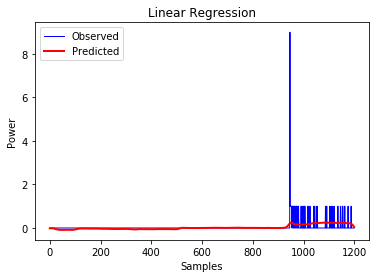

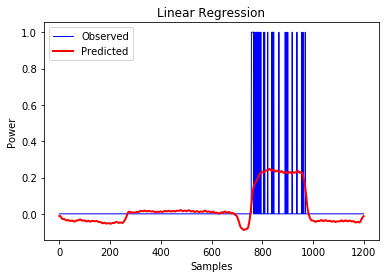

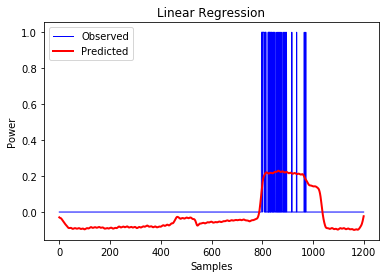

In [72]:
for i in range(len(y_test)):
    samples = range(len(y_test[i]))
    plt.plot(samples,y_test[i], color='blue', linewidth=1, label = 'Observed') 
    plt.plot(samples,y_pred[i], color='red', linewidth=2, label = 'Predicted') 
    plt.title('Linear Regression')
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Power')
    plt.show()